<font size="12">  Spike train cross-correlation </font>

The Spike cross-correlation script is based on the one available at https://github.com/thierrynieus/cross_corr

It takes advantage of sparse matrices operations to speed up calculation.

References: 

    1. Garofalo, M., Nieus, T., Massobrio, P., and Martinoia, S. (2009). Evaluation of the Performance of Information Theory-Based Methods and Cross-Correlation to Estimate the Functional Connectivity in Cortical Networks. PLoS ONE 4, e6482. doi: 10.1371/journal.pone.0006482.
    
    2. Nieus, T., D’Andrea, V., Amin, H., Di Marco, S., Safaai, H., Maccione, A., et al. (2018). State-dependent representation of stimulus-evoked activity in high-density recordings of neural cultures. Sci Rep 8, 5578. doi: 10.1038/s41598-018-23853-x.

# Load data and perform some preliminary analysis

In [1]:
import numpy as np

In [2]:
params = {'dt': 0.5, 'tw': 5, 'tmax': 6e5, 'corr': True}

In [3]:
def load_data(fname_spike_train, update_tmax=True):
    """Load data."""
    data = np.load(fname_spike_train, allow_pickle=1)
    # convert to list of spike trains
    spk_trains = []
    id_ch_unique = np.unique(data[0, :])
    for id_ch in id_ch_unique:
        idx = np.where(data[0, :] == id_ch)[0]
        spk_trains.append(data[1, idx])
    tmax = np.max(data[1, idx])
    if update_tmax:
        params['tmax'] = tmax
    # id_ch_unique: id <-> (row, column) spatial coordinatesa
    return spk_trains, id_ch_unique, tmax


In [4]:
# get the data from the web ... 
import os

if not(os.path.isdir('data')):
    print("Folder <<data>> created!")
    os.makedirs('data')
if not(os.path.isfile('data/data.npy')):
    print("Transfer data.npy!")
    str_get = "https://unimi2013-my.sharepoint.com/:u:/g/personal/thierry_nieus_unimi_it/EYxkNBwY_LNNvaYMNoYQMOMBm0EBC-hHMdMMs23KfSVTLg?e=NHjjXA&download=1"
    wget = "os.system"
    os.system("wget --no-check-certificate \"%s\" -q -O data/data.npy" % str_get)
fn = 'data/data.npy'

In [5]:
spk_trains_tmp, id_ch_tmp, tmax = load_data(fn)
tmax /= 1000 # tmax in seconds
print('%d spike trains loaded ' % len(spk_trains_tmp))
print('max time of recording (s) %g ' %tmax)

793 spike trains loaded 
max time of recording (s) 565.398 


## Filter data

In [6]:
import pylab as plt

In [7]:
mfr_min = 0.1 # Hz
spk_trains, id_ch = [], []
mfr_lst = []
for st, ic in zip(spk_trains_tmp, id_ch_tmp):
    mfr = len(st) / tmax  # Hz    
    if mfr > mfr_min:
        # spike train has enough spikes
        spk_trains.append(st)
        id_ch.append(ic)
        mfr_lst.append(mfr)
print('%d spike trains retained ' % len(spk_trains)) 

793 spike trains retained 


## Report distribution of mean firing rates.

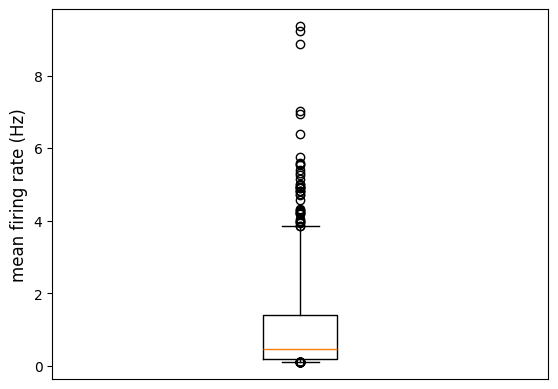

In [8]:
plt.boxplot(mfr_lst, whis=[5, 95])
plt.xticks([])
plt.ylabel('mean firing rate (Hz)', fontsize=12);

# Compute spike cross-correlation

In [38]:
def format_spike_train(spk_trains):
    """Format spike trains.

    spk_trains  a list of spike trains
    """
    idx_spk_tr, len_spk_tr = [], []
    for spk_train in spk_trains:
        spk_train_arr = np.array(spk_train)
        idx_spk_train = (spk_train_arr/params['dt']).astype(int)
        len_spk_tr.append(len(idx_spk_train))
        idx_spk_tr.append(idx_spk_train)
    return idx_spk_tr, len_spk_tr


def calc_cc(idx_spk_tr, len_spk_tr, params):
    import time
    from scipy.sparse import csr_matrix, lil_matrix
    
    timo = time.time()
    max_idx = np.max([np.max(i) for i in idx_spk_tr])
    num_trains = len(idx_spk_tr)
    nstep = int(params['tw'] / params['dt'])
    padded = lil_matrix((len(idx_spk_tr),max_idx+2*nstep+1))
    ccmat= np.zeros((nstep*2+1,num_trains,num_trains))
    for i in range(num_trains):
        padded[i,(idx_spk_tr[i]-1+nstep)]=1
    padded = csr_matrix(padded)
    ref = padded[:,nstep:-(nstep+1)]
    
    sizes = np.array(len_spk_tr)
    sizes = sizes.reshape(len(sizes), 1)
    lijs = csr_matrix(sizes.dot(sizes.T))
    lijs_sc = (lijs/params['tmax'])*params['dt']
    for k in range(nstep*2+1): 
        ccmat_ = ref.dot(padded[:,k:(max_idx+k)].T)
        #sizes = ccmat.sum(axis=0).T
        ccmat_ -= lijs_sc
        ccmat_ /=  lijs.sqrt()
        ccmat[k] = ccmat_
    print('cross-corr computed in {:.2f} seconds \n'.format(time.time()-timo))

    return ccmat

In [39]:
idx_spk_tr, len_spk_tr = format_spike_train(spk_trains)

In [40]:
ccmat = calc_cc(idx_spk_tr, len_spk_tr, params)

cross-corr computed in 0.79 seconds 



#### multiprocessing just for fun 

In [41]:
from  multiprocess import  Process
import time 

def my_func(idx_spk_tr, len_spk_tr, param, repetitions):
    # repeat the funtion calc_cc "repetitions" times
    
    for _ in range(repetitions):
        calc_cc(idx_spk_tr, len_spk_tr, param)


num_processes = os.cpu_count()
repetitions = 1

processes = []

for i in range(num_processes):
    processes.append(Process(target=my_func, args=( idx_spk_tr, len_spk_tr, params, repetitions)))

to = time.time()
for p in processes:
    p.start()

for p in processes:
    p.join()
print('{:.2f} ended'.format(time.time() - to))

cross-corr computed in 1.72 seconds 
cross-corr computed in 1.72 seconds 


cross-corr computed in 1.74 seconds 

cross-corr computed in 1.75 seconds 
cross-corr computed in 1.74 seconds 


cross-corr computed in 1.75 seconds 

cross-corr computed in 1.77 seconds 

cross-corr computed in 1.77 seconds 

1.82 ended


## Analyze the correlations

In [12]:
def get_cc_list(ccmat):
    num_trains = ccmat.shape[1]
    idx_sd = []
    idx = np.triu_indices(num_trains, 1)
    for idx_src, idx_dst in zip(*idx):
        idx_sd.append((idx_src, idx_dst))
    cc_lst = []
    for k in idx_sd:
        i,j  = k
        cc_lst.append(ccmat[:,i,j])
    return cc_lst, idx_sd

In [13]:
cc_lst,  idx_sd = get_cc_list(ccmat)

In [14]:
# Define some useful functions
def get_row_col(id_ch):
    """Return row and column of channel id_ch."""
    row = id_ch // 64
    col = id_ch % 64    
    return row, col

def chan_dist(rc_src, rc_dst):
    """Compute distance between two channels/electrodes."""
    pitch = 80 # um
    d2 = (rc_src[0] - rc_dst[0])**2 + (rc_src[1] - rc_dst[1])**2
    d = np.sqrt(d2) * pitch
    return d

In [15]:
dout = {}
keys = ['cc-peak', 'cc-peak-time-lag (ms)', 'distance (um)', 'velocity (mm/s)']
for key in keys:
    dout[key] = []

tcc = np.arange(-params['tw'], params['tw'] + params['dt'], params['dt'])

for k, cc in enumerate(cc_lst):
    # cc-max
    cc_max = np.max(cc)
    idx_max = np.argmax(cc)
    t_peak = tcc[idx_max]
    # distance
    idx_src, idx_dst = idx_sd[k]
    rc_src = get_row_col(id_ch[idx_src])
    rc_dst = get_row_col(id_ch[idx_dst])
    dist = chan_dist(rc_src, rc_dst)
    # velocity
    if t_peak:
        vel = dist / t_peak  # um / ms = mm/s
    else:
        vel = 1e10
    # store results
    dout['cc-peak'].append(cc_max)
    dout['cc-peak-time-lag (ms)'].append(t_peak)
    dout['distance (um)'].append(dist)
    dout['velocity (mm/s)'].append(abs(vel))

In [16]:
# define data frame and rank it based on the spike cross-correlation values (from highest to lowest)
import pandas as pd
df = pd.DataFrame(dout)
df.sort_values('cc-peak', ascending=False, inplace=True)
df.head(n=20)

,cc-peak,cc-peak-time-lag (ms),distance (um),velocity (mm/s)
83193,0.393650,0.0,80.000000,1.000000e+10
303443,0.392940,0.5,80.000000,1.600000e+02
130770,0.233888,1.5,252.982213,1.686548e+02
139738,0.232774,-0.5,288.444102,5.768882e+02
202417,0.134919,0.0,80.000000,1.000000e+10
44307,0.133154,0.5,288.444102,5.768882e+02
84551,0.132141,-2.5,4882.622246,1.953049e+03
202889,0.126756,0.0,80.000000,1.000000e+10
233440,0.124302,0.0,80.000000,1.000000e+10
151876,0.123927,0.0,80.000000,1.000000e+10
